# EFI Example: Behrens–Fisher problem



## Define EFI Neural Network

For Behrens–Fisher problem, we consider two Gaussian distributions $N(\mu_1,\sigma_1^2)$ and $N(\mu_2,\sigma_2^2)$.
Suppose that two independent random samples of sizes $n_1$ and $n_2$ are drawn from them, respectively. The structural equations are given by

$$
\begin{split}
    y_{1i}&=\mu_1+\sigma_1 z_{1i}, \quad i=1,\ldots,n_1, \\
    y_{2i}&=\mu_2+\sigma_2 z_{2i}, \quad i=1,\ldots,n_2, \
\end{split}
$$

where $z_{i1}, z_{i2}\sim N(0,1)$ independently.
The Behrens-Fisher problem pertains to the inference for the difference $\mu_1-\mu_2$ when the ratio $\sigma_1/\sigma_2$ is unknown. We can apply EFI to this problem by solving the two structural equations separately(introdce two Neural Networks): one for $(\mu_1, \sigma_1)$ and the other for $(\mu_2,\sigma_2)$.  

Let $\{\hat{\mu}_1^{(k)}: k=1,2,\ldots, M\}$ and $\{\hat{\mu}_2^{(k)}: k=1,2,\ldots,M\}$ denote, respectively, the fiducial samples for the population means produced by the two EFI solvers. Then, the 95\% confidence interval for $\mu_1-\mu_2$ can be directly constructed by finding the 2.5th and 97.5th percentiles of the samples  $\{\hat{\mu}_1^{(k)} - \hat{\mu}_2^{(k)}: k=1,2,\ldots,M\}$

In [1]:
import torch
import torch.nn as nn

import numpy as np

import arviz as az

import scipy
from scipy import stats
from scipy.stats import t
from scipy.stats import chi2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches

import seaborn as sns

import random




def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.002)
            if m.bias!=None:
              m.bias.data.zero_()
        elif isinstance(m,nn.BatchNorm2d):  # BatchNorm weight init
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()

        # Activation function
        self.relu = nn.ReLU()

        # Define layers
        self.fc_Y1 = nn.Linear(1, hidden_dim)
        self.fc_Y2 = nn.Linear(1, hidden_dim)
        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, y1, y2):
        # Pass inputs through the first layer and apply ReLU
        y1_out = self.fc_Y1(y1)
        y2_out = self.fc_Y2(y2)

        # Concatenate the outputs
        concatenated = self.relu(torch.cat((y1_out, y2_out), dim=1))

        # Pass through the next layers
        hidden_out = self.fc1(concatenated)
        output = self.fc2(hidden_out)

        return output


## Training EFI networks

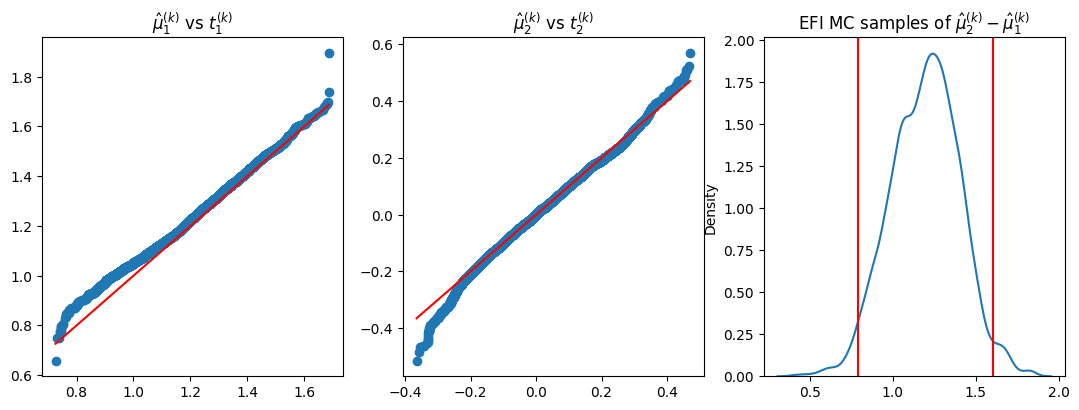

Replicate: 1 // cover 1.0 // length 0.8116312891244887


In [2]:
## Random seed

import random

se=2000

np.random.seed(se)
torch.manual_seed(se)

mseloss=nn.MSELoss()

## True DGP settings

true_mu=1
N=50

## Replicates

S=1 ## S=100
Z_dataset=torch.randn(S,N,2)


## Sparse DNN settings

l=1e-2
sigma_0=np.sqrt(1e-5)
sigma_1=np.sqrt(0.02)

c1=np.log(l)-np.log(1-l)+1/2*np.log(sigma_0**2)-1/2*np.log(sigma_1**2)
c2=1/2/sigma_0**2-1/2/sigma_1**2

threshold=np.sqrt(np.log( (1-l)/l *sigma_1/sigma_0 )/(1/(2*sigma_0**2)-1/(2*sigma_1**2)))


## Inference results

mu_cover=np.zeros(S)
ci_length=np.zeros(S)

## EFI settings

lambda_1=100
lambda_2=20


for s in range(S):

  ## Prepare data

  Z1=Z_dataset[s][:,0].view(N,1)
  Z2=Z_dataset[s][:,1].view(N,1)

  sigma1s=1
  sigma2s=1

  X1=np.sqrt(sigma1s)*Z1+true_mu
  X2=np.sqrt(sigma2s)*Z2
  X1=X1.cuda()
  X2=X2.cuda()

  ## Initialize the imputed Z (latent variable), Settings of SGHMC

  alpha=0.05
  alpha2=0.05
  Z_o1=(1*torch.randn(N,1)).cuda().requires_grad_()
  Z_o2=(1*torch.randn(N,1)).cuda().requires_grad_()

  momentum_Z_o1=torch.zeros(Z_o1.size()).cuda()
  momentum_Z_o2=torch.zeros(Z_o2.size()).cuda()

  ### Initial setting

  lr_d=0.01/N
  lr_g=0.05/N

  ## Define networks

  Encoder1=FeedforwardNeuralNetModel(2,10,2).cuda()
  Encoder1.apply(initialize_weights)

  Encoder2=FeedforwardNeuralNetModel(2,10,2).cuda()
  Encoder2.apply(initialize_weights)

  E_optimizer=torch.optim.SGD(list(Encoder1.parameters())+list(Encoder2.parameters()),lr=lr_d )


  mu1_collection=[]
  mu2_collection=[]
  subsample_size=N

  K=10000
  MM=40000

  batch_size=int(N/subsample_size)
  total_iter=(K+MM)*batch_size
  total_index=list(range(N))




  iter=0


  for epoch in range(K+MM):

    for batch in range(batch_size):

      idx=total_index[batch*subsample_size:batch*subsample_size+subsample_size]

      lr_g=  2800/(100000+(iter+1)**(4/7))/N
      lr_g2= 2800/(100000+(iter+1)**(4/7))/N
      lr_d=  2800/(100000+(iter+1)**(4/7))/N


      for param_group in E_optimizer.param_groups:
        param_group['lr'] = lr_d


      ##### 1. Latent variable sampling (Sample Z)

      thetas1=Encoder1(X1[idx],Z_o1[idx])
      thetas2=Encoder2(X2[idx],Z_o2[idx])
      theta1, s_sigma1=thetas1[:,0], (thetas1[:,1])
      theta2, s_sigma2=thetas2[:,0], (thetas2[:,1])

      bar_theta1, bar_sigma1=torch.mean(theta1), torch.mean(torch.exp(s_sigma1))
      bar_theta2, bar_sigma2=torch.mean(theta2), torch.mean(torch.exp(s_sigma2))

      tilde_X1=bar_theta1+  bar_sigma1*Z_o1[idx]
      tilde_X2=bar_theta2+  bar_sigma2*Z_o2[idx]

      Z_loss=lambda_2*N*mseloss(X1[idx],tilde_X1)
      Z_loss+=lambda_2*N*mseloss(X2[idx],tilde_X2)

      Z_loss+=N*torch.mean(Z_o1[idx]**2)/2+N*torch.mean(Z_o2[idx]**2)/2 #+1*(torch.mean(Z_o1**2)-1)**2+1*(torch.mean(Z_o2**2)-1)**2
      Z_loss+=lambda_1*N*mseloss(theta1.view(N,1),bar_theta1.repeat(N,1))+lambda_1*N*mseloss(torch.exp(s_sigma1).view(N,1),bar_sigma1.repeat(N,1))
      Z_loss+=lambda_1*N*mseloss(theta2.view(N,1),bar_theta2.repeat(N,1))+lambda_1*N*mseloss(torch.exp(s_sigma2).view(N,1),bar_sigma2.repeat(N,1))


      if Z_o1.grad is not None:
        Z_o1.grad.zero_()
        Z_o2.grad.zero_()
        E_optimizer.zero_grad()

      Z_loss.backward()

      momentum_Z_o1 *=(1-alpha)
      momentum_Z_o1 += -lr_g * Z_o1.grad+ torch.FloatTensor(Z_o1.shape).cuda().normal_().mul(np.sqrt(2*alpha*lr_g))

      Z_o1.data += momentum_Z_o1

      momentum_Z_o2*=(1-alpha2)
      momentum_Z_o2 += -lr_g2 * Z_o2.grad+ torch.FloatTensor(Z_o2.shape).cuda().normal_().mul(np.sqrt(2*alpha2*lr_g2))

      Z_o2.data += momentum_Z_o2


      #### 2. DNN weights update (Optimize W)

      thetas1=Encoder1(X1[idx],Z_o1[idx])
      thetas2=Encoder2(X2[idx],Z_o2[idx])
      theta1, s_sigma1=thetas1[:,0], (thetas1[:,1])
      theta2, s_sigma2=thetas2[:,0], (thetas2[:,1])

      bar_theta1, bar_sigma1=torch.mean(theta1), torch.mean(torch.exp(s_sigma1))
      bar_theta2, bar_sigma2=torch.mean(theta2), torch.mean(torch.exp(s_sigma2))

      tilde_X1=bar_theta1+  bar_sigma1*Z_o1[idx]
      tilde_X2=bar_theta2+  bar_sigma2*Z_o2[idx]

      E_loss=lambda_2*N*mseloss(X1[idx],tilde_X1)
      E_loss+=lambda_2*N*mseloss(X2[idx],tilde_X2)

      E_loss+=lambda_1*N*mseloss(theta1.view(N,1),bar_theta1.repeat(N,1))+lambda_1*N*mseloss(torch.exp(s_sigma1).view(N,1),bar_sigma1.repeat(N,1))
      E_loss+=lambda_1*N*mseloss(theta2.view(N,1),bar_theta2.repeat(N,1))+lambda_1*N*mseloss(torch.exp(s_sigma2).view(N,1),bar_sigma2.repeat(N,1))


      E_optimizer.zero_grad()

      E_loss.backward()


      with torch.no_grad():
        for param in Encoder1.parameters():
          temp=1/(torch.exp(c2*torch.mul(param.data,param.data)+c1)+1)
          prior=-torch.mul(param.data,temp)/sigma_0**2-torch.mul(param.data,(1-temp))/sigma_1**2
          param.grad.data -=prior/N

        for param2 in Encoder2.parameters():
          temp=1/(torch.exp(c2*torch.mul(param2.data,param2.data)+c1)+1)
          prior=-torch.mul(param2.data,temp)/sigma_0**2-torch.mul(param2.data,(1-temp))/sigma_1**2
          param2.grad.data -=prior/N


      E_optimizer.step()

      iter+=1

    ## MC samples

    if (epoch>K) and (iter%4==0) :

      thetas1=Encoder1(X1,Z_o1)
      thetas2=Encoder2(X2,Z_o2)
      theta1, s_sigma1=thetas1[:,0], (thetas1[:,1])
      theta2, s_sigma2=thetas2[:,0], (thetas2[:,1])

      bar_theta1, bar_sigma1=torch.mean(theta1), torch.mean(torch.exp(s_sigma1))
      bar_theta2, bar_sigma2=torch.mean(theta2), torch.mean(torch.exp(s_sigma2))

      mu1_collection.append(bar_theta1.detach().cpu().numpy())
      mu2_collection.append(bar_theta2.detach().cpu().numpy())

  mu1_collection=np.stack(mu1_collection)
  mu2_collection=np.stack(mu2_collection)

  mean_diff=mu1_collection-mu2_collection

  hdi_diff=np.quantile(mean_diff,[0.025,0.975],axis=0).T

  hdi_mu1=np.quantile(mu1_collection,[0.025,0.975],axis=0).T
  hdi_mu2=np.quantile(mu2_collection,[0.025,0.975],axis=0).T


  if true_mu<=hdi_diff[1] and  true_mu>=hdi_diff[0]:
    mu_cover[s]=1

  ci_length[s]=(hdi_diff[1]-hdi_diff[0])

  q1=t.ppf(0.975, N-1, loc=0, scale=1)
  q2=t.ppf(0.975, N-1, loc=0, scale=1)


  mean1_l=(torch.mean(X1)-q1*torch.std(X1)/np.sqrt(N)).detach().cpu().numpy()
  mean1_u=(torch.mean(X1)+q1*torch.std(X1)/np.sqrt(N)).detach().cpu().numpy()


  mean2_l=(torch.mean(X2)-q2*torch.std(X2)/np.sqrt(N)).detach().cpu().numpy()
  mean2_u=(torch.mean(X2)+q2*torch.std(X2)/np.sqrt(N)).detach().cpu().numpy()


  fig, axes = plt.subplots(1, 3,figsize=(13.2,4.4))
  empirical_t1=torch.mean(X1).detach().cpu().numpy()-(torch.std(X1).detach().cpu().numpy()/np.sqrt(N)*np.random.standard_t(N-1, size=len(mu1_collection)))
  axes[0].scatter(np.sort(mu1_collection), np.sort(empirical_t1 ))

  plot_x = np.linspace(min(mu1_collection),max(mu1_collection),100)
  plot_y = plot_x
  axes[0].plot(plot_x,plot_y,"r")
  axes[0].set_title(r"$\hat{\mu}_1^{(k)}$" +" vs "+ r"$t_1^{(k)}$"  )


  empirical_t2=torch.mean(X2).detach().cpu().numpy()-(torch.std(X2).detach().cpu().numpy()/np.sqrt(N)*np.random.standard_t(N-1, size=len(mu2_collection)))

  axes[1].scatter(np.sort(mu2_collection),np.sort(empirical_t2))
  plot_x = np.linspace(min(mu2_collection),max(mu2_collection),100)
  plot_y = plot_x
  axes[1].plot(plot_x,plot_y,"r")
  axes[1].set_title(r"$\hat{\mu}_2^{(k)}$" +" vs "+ r"$t_2^{(k)}$"  )


  sns.kdeplot(mean_diff,ax=axes[2])
  axes[2].axvline(x=hdi_diff[0], ymin=0, ymax=1,color="r",label="EFI")
  axes[2].axvline(x=hdi_diff[1], ymin=0, ymax=1,color="r")
  axes[2].set_title(r"EFI MC samples of $\hat{\mu}_2^{(k)} - \hat{\mu}_1^{(k)}$")

  #sns.kdeplot(mu1_collection,ax=axes[0])
  # axes[0].axvline(x=hdi_mu1[0], ymin=0, ymax=1,color="r",label="EFI")
  # axes[0].axvline(x=hdi_mu1[1], ymin=0, ymax=1,color="r")
  # axes[0].axvline(x=mean1_l, ymin=0, ymax=1,color="b",label="T-dist")
  # axes[0].axvline(x=mean1_u, ymin=0, ymax=1,color="b")

  #sns.kdeplot(mu2_collection,ax=axes[1])
  # axes[1].axvline(x=hdi_mu2[0], ymin=0, ymax=1,color="r",label="EFI")
  # axes[1].axvline(x=hdi_mu2[1], ymin=0, ymax=1,color="r")
  # axes[1].axvline(x=mean2_l, ymin=0, ymax=1,color="b",label="T-dist")
  # axes[1].axvline(x=mean2_u, ymin=0, ymax=1,color="b")

  plt.show()

  print("Replicate:",s+1, "//", "cover",np.sum(mu_cover)/(s+1),"//", "length",np.sum(ci_length)/(s+1))

